In [ ]:
import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.interpolate import CubicSpline
from time import time
import random
import helper_scripts
import unsupervised_scripts

## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())
save_dir = (input('Enter the path to your save directory:').strip() or os.getcwd())
## Load Image
from tkinter import*
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T
# image.shape

##Remove NaNs and inf
image_vec[np.isinf(image_vec)] = 0
image_vec[np.isnan(image_vec)] = 0

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2750)):').strip() or '2750')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100):').strip() or '3100')
num_samp = int(np.shape(image_vec)[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
image_standard = preprocessing.spectral_standardization(np.flip(image_vec,axis=1))
image_max = np.max(np.percentile(image_standard,99,axis=0))
image_norm = helper_scripts.normalize_manual(image_standard, max_val=image_max, min_val=np.median(image_standard[:,:ch_start]))
image_norm = image_norm-np.median(image_norm[:,:ch_start],axis=1)[0]



Text(0, 0.5, 'Normalized Intensity (A.U.)')

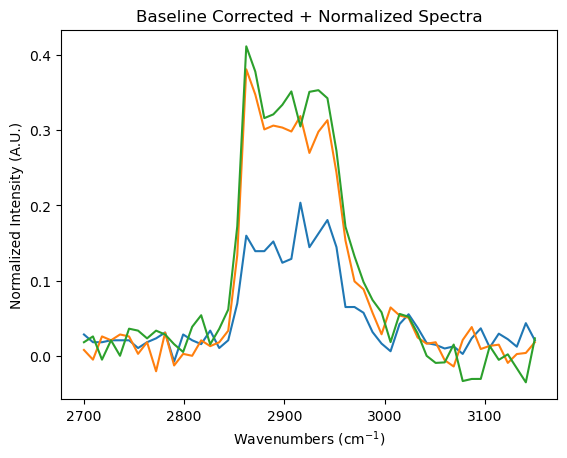

In [3]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [4]:
## Initialize Kmeans clusters
kmeans_cluster = unsupervised_scripts.K_means_cluster(image_norm)

In [5]:
## Optimizing Silhouette Score (OPTIONAL)
cluster_range = int(input('Enter range of clusters to optimize: '))

kmeans_cluster.kmeans_silhoutette_score(cluster_range+1)

__________________________________________________________________________________
init		time	inertia	silhouette
Clusters: 2
PCA-based	1.185s	133759	0.474
Clusters: 3
PCA-based	0.636s	94247	0.327
Clusters: 4
PCA-based	0.897s	81299	0.246
Clusters: 5
PCA-based	1.348s	75271	0.207
Clusters: 6
PCA-based	2.319s	70115	0.197
Clusters: 7
PCA-based	1.554s	66237	0.169
Clusters: 8
PCA-based	2.611s	63720	0.160
Clusters: 9
PCA-based	2.422s	61221	0.158
Clusters: 10
PCA-based	3.384s	59632	0.145
__________________________________________________________________________________


In [5]:
## Selection of k-means number (default=7)
n_digits=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans = kmeans_cluster.kmeans(n_digits)

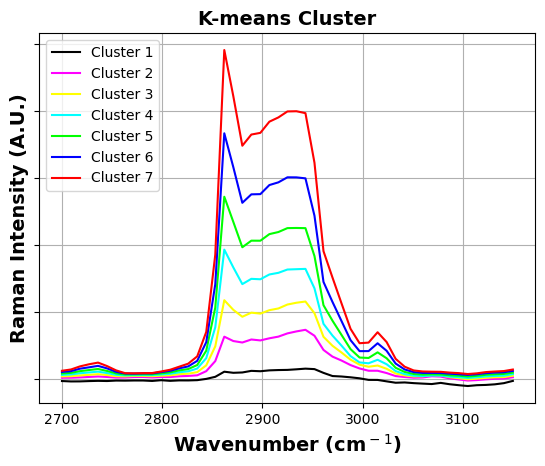

<Figure size 640x480 with 0 Axes>

In [6]:
## Visualize Graph of Cluster Centers
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000']
color_list = np.empty(n_digits, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])
save_input = helper_scripts.save_input()
kmeans_cluster.kmeans_graph(kmeans, wavenumbers, save_input, color_list, save_dir=save_dir)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


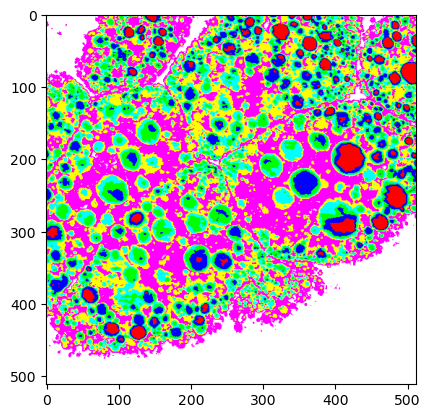

In [7]:
## Visualize Clustered Image
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000']
color_list = np.empty(n_digits, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
save_input = helper_scripts.save_input()
kmeans_cluster.kmeans_image(kmeans, image, save_input, color_list, save_dir=save_dir)
